## BAYESIAN REGRESSION


In [ ]:
import pandas as pd
import bambi as bmb
import arviz as az
from sklearn.metrics import roc_auc_score

# Load the data
data = pd.read_csv('RF_imputation_NEW.csv')

# Drop unwanted columns
data = data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id'])

# Normalize the predictors
predictor_columns = data.columns.difference(['outcome'])
data[predictor_columns] = (data[predictor_columns] - data[predictor_columns].mean()) / data[predictor_columns].std()

# Split the data into training and validation sets
train_data = data.sample(frac=0.7, random_state=213)
valid_data = data.drop(train_data.index)

# Define and fit the Bayesian logistic regression model using Laplace approximation
model = bmb.Model('outcome ~ ' + ' + '.join(predictor_columns), train_data, family='bernoulli')
fitted_model = model.fit(inference_method="laplace")

# Summarize the model
print(fitted_model.summary())

# Evaluate the model performance on the training set
train_preds_prob = fitted_model.predict(train_data)
train_auc_value = roc_auc_score(train_data['outcome'], train_preds_prob)
print("Train AUC:", train_auc_value)

# Evaluate the model performance on the validation set
valid_preds_prob = fitted_model.predict(valid_data)
valid_auc_value = roc_auc_score(valid_data['outcome'], valid_preds_prob)
print("Validation AUC:", valid_auc_value)



In [5]:
!pip install aesara



In [1]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Load the data
data = pd.read_csv("RF_imputation_NEW.csv")

# Drop unnecessary columns
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id', 'COPD', 'CHD_with_no_MI'], inplace=True)

# Ensure the 'outcome' column is present and clean
if 'outcome' not in data.columns:
    raise ValueError("The 'outcome' column does not exist in the dataframe.")
if not data['outcome'].isin([0, 1]).all():
    raise ValueError("The 'outcome' column contains values other than 0 and 1.")

# Convert 'outcome' to integers
data['outcome'] = data['outcome'].astype(int)

# Normalize the predictors
predictor_names = data.columns.difference(['outcome'])
scaler = StandardScaler()
data[predictor_names] = scaler.fit_transform(data[predictor_names])

# Split the data into Training and Validation Sets
train_data, valid_data = train_test_split(data, test_size=0.3, random_state=213)

# Prepare data for Stan model
stan_data = {
    'N': train_data.shape[0],
    'K': len(predictor_names),
    'X': train_data[predictor_names].values,
    'y': train_data['outcome'].values
}

# Compile Stan model
model = CmdStanModel(stan_file='logistic_regression.stan')

# Sample from the posterior
fit = model.sample(data=stan_data, seed=213, chains=4, parallel_chains=4, iter_sampling=1000)

# Extract the samples
beta_samples = fit.stan_variable('beta')
alpha_samples = fit.stan_variable('alpha')

# Calculate the mean and HDI (Highest Density Interval) for the coefficients
beta_means = beta_samples.mean(axis=0)
beta_hdi = np.percentile(beta_samples, [2.5, 97.5], axis=0)

# Selected features based on HDI not including zero
selected_features = predictor_names[(beta_hdi[0] > 0) | (beta_hdi[1] < 0)]
print("Selected features:", selected_features)

# Posterior predictive checks
y_pred_train = fit.stan_variable('y_pred').mean(axis=0)
train_auc_value = roc_auc_score(train_data['outcome'], y_pred_train)
print("Train AUC:", train_auc_value)

# Prepare validation data for prediction
stan_data_valid = {
    'N': valid_data.shape[0],
    'K': len(predictor_names),
    'X': valid_data[predictor_names].values,
    'y': valid_data['outcome'].values
}

# Generate predictions for validation set
fit_valid = model.sample(data=stan_data_valid, seed=213, chains=4, parallel_chains=4, iter_sampling=1000)

# Extract and calculate validation predictions
y_pred_valid = fit_valid.stan_variable('y_pred').mean(axis=0)
test_auc_value = roc_auc_score(valid_data['outcome'], y_pred_valid)
print("Test AUC:", test_auc_value)


10:06:36 - cmdstanpy - INFO - compiling stan file /Users/peterdunson/Documents/DMML-Survival-Analysis-NEW/logistic_regression.stan to exe file /Users/peterdunson/Documents/DMML-Survival-Analysis-NEW/logistic_regression
10:06:45 - cmdstanpy - INFO - compiled model executable: /Users/peterdunson/Documents/DMML-Survival-Analysis-NEW/logistic_regression
10:06:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:06:49 - cmdstanpy - INFO - CmdStan done processing.


10:06:49 - cmdstanpy - INFO - CmdStan start processing


Selected features: Index(['Blood_calcium', 'Lactic_acid', 'Leucocyte', 'PCO2', 'RDW', 'SP_O2',
       'Urea_nitrogen', 'heart_rate'],
      dtype='object')
Train AUC: 0.8766734667856688


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:06:50 - cmdstanpy - INFO - CmdStan done processing.



Test AUC: 0.9308129809300769


10:10:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:10:26 - cmdstanpy - INFO - CmdStan done processing.



          mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[0]   0.40  0.35   -0.25     1.08       0.01     0.00   3504.79   5054.51   
beta[1]  -0.16  0.18   -0.49     0.17       0.00     0.00   9480.81   6051.90   
beta[2]  -0.38  0.24   -0.82     0.09       0.00     0.00   8396.82   6202.22   
beta[3]  -0.70  0.61   -1.89     0.38       0.01     0.01   3494.06   4978.95   
beta[4]  -0.39  0.15   -0.66    -0.09       0.00     0.00   9402.79   6680.49   
beta[5]   0.20  0.16   -0.08     0.52       0.00     0.00   8137.84   6400.46   
beta[6]  -0.11  0.47   -0.96     0.79       0.01     0.01   3418.88   4786.20   
beta[7]   0.13  0.60   -0.99     1.27       0.01     0.01   3415.06   4717.11   
beta[8]   0.14  0.15   -0.13     0.43       0.00     0.00   9691.25   5678.54   
beta[9]  -0.28  0.24   -0.72     0.19       0.00     0.00   8803.31   6241.91   
beta[10] -0.27  0.18   -0.59     0.07       0.00     0.00   8160.56   6512.02   
beta[11] -0.00  0.15   -0.2

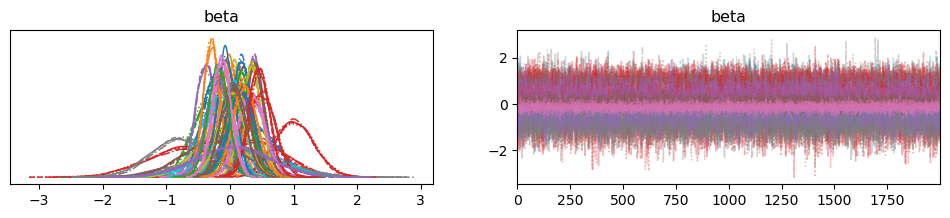

10:10:29 - cmdstanpy - INFO - CmdStan start processing


Selected features: Index(['Blood_calcium', 'Lactic_acid', 'Leucocyte', 'PCO2', 'RDW', 'SP_O2',
       'Urea_nitrogen', 'heart_rate'],
      dtype='object')
Train AUC: 0.875831952059161


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:10:31 - cmdstanpy - INFO - CmdStan done processing.



Test AUC: 0.9320843091334895


In [2]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import arviz as az
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("RF_imputation_NEW.csv")

# Drop unnecessary columns
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id', 'COPD', 'CHD_with_no_MI'], inplace=True)

# Ensure the 'outcome' column is present and clean
if 'outcome' not in data.columns:
    raise ValueError("The 'outcome' column does not exist in the dataframe.")
if not data['outcome'].isin([0, 1]).all():
    raise ValueError("The 'outcome' column contains values other than 0 and 1.")

# Convert 'outcome' to integers
data['outcome'] = data['outcome'].astype(int)

# Normalize the predictors
predictor_names = data.columns.difference(['outcome'])
scaler = StandardScaler()
data[predictor_names] = scaler.fit_transform(data[predictor_names])

# Split the data into Training and Validation Sets
train_data, valid_data = train_test_split(data, test_size=0.3, random_state=213)

# Prepare data for Stan model
stan_data = {
    'N': train_data.shape[0],
    'K': len(predictor_names),
    'X': train_data[predictor_names].values,
    'y': train_data['outcome'].values
}

# Compile Stan model
model = CmdStanModel(stan_file='logistic_regression.stan')

# Sample from the posterior
fit = model.sample(data=stan_data, seed=213, chains=4, parallel_chains=4, iter_sampling=2000, iter_warmup=1000)

# Extract and summarize all coefficients
beta_summary = az.summary(fit, var_names=['beta'], round_to=2)
print(beta_summary)

# To visualize the coefficients
az.plot_trace(fit, var_names=['beta'])
plt.show()

# Calculate the mean and HDI (Highest Density Interval) for the coefficients
beta_samples = fit.stan_variable('beta')
alpha_samples = fit.stan_variable('alpha')
beta_means = beta_samples.mean(axis=0)
beta_hdi = np.percentile(beta_samples, [2.5, 97.5], axis=0)

# Selected features based on HDI not including zero
selected_features = predictor_names[(beta_hdi[0] > 0) | (beta_hdi[1] < 0)]
print("Selected features:", selected_features)

# Posterior predictive checks
y_pred_train = fit.stan_variable('y_pred').mean(axis=0)
train_auc_value = roc_auc_score(train_data['outcome'], y_pred_train)
print("Train AUC:", train_auc_value)

# Prepare validation data for prediction
stan_data_valid = {
    'N': valid_data.shape[0],
    'K': len(predictor_names),
    'X': valid_data[predictor_names].values,
    'y': valid_data['outcome'].values
}

# Generate predictions for validation set
fit_valid = model.sample(data=stan_data_valid, seed=213, chains=4, parallel_chains=4, iter_sampling=2000, iter_warmup=1000)

# Extract and calculate validation predictions
y_pred_valid = fit_valid.stan_variable('y_pred').mean(axis=0)
test_auc_value = roc_auc_score(valid_data['outcome'], y_pred_valid)
print("Test AUC:", test_auc_value)


12:05:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:23 - cmdstanpy - INFO - CmdStan done processing.



                           Feature  mean    sd  hdi_3%  hdi_97%  r_hat
beta[0]                  Anion_gap  0.51  0.35   -0.12     1.18    1.0
beta[1]                        BMI  0.01  0.17   -0.29     0.33    1.0
beta[2]                  Basophils  0.00  0.15   -0.29     0.28    1.0
beta[3]                Bicarbonate -0.94  0.60   -2.09     0.16    1.0
beta[4]              Blood_calcium -0.41  0.15   -0.70    -0.13    1.0
beta[5]            Blood_potassium  0.20  0.16   -0.10     0.50    1.0
beta[6]               Blood_sodium -0.15  0.46   -1.04     0.69    1.0
beta[7]                   Chloride  0.26  0.60   -0.92     1.34    1.0
beta[8]            Creatine_kinase  0.00  0.32   -0.61     0.55    1.0
beta[9]                 Creatinine -0.58  0.28   -1.12    -0.07    1.0
beta[10]  Diastolic_blood_pressure -0.35  0.19   -0.70     0.00    1.0
beta[11]                        EF -0.14  0.14   -0.41     0.13    1.0
beta[12]              Hyperlipemia  0.16  0.20   -0.21     0.52    1.0
beta[

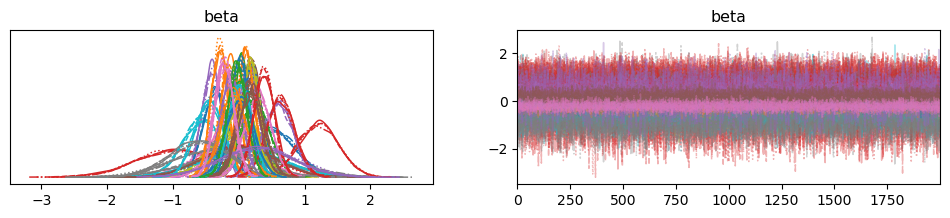

12:05:25 - cmdstanpy - INFO - CmdStan start processing


Selected features: Index(['Blood_calcium', 'Creatinine', 'PCO2', 'PH', 'Renal_failure', 'SP_O2',
       'Urea_nitrogen', 'heart_rate'],
      dtype='object')
Train AUC: 0.8650372404919209


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:27 - cmdstanpy - INFO - CmdStan done processing.



Test AUC: 0.9287666307083784


In [6]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import arviz as az
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("RF_imputation_NEW.csv")

# Drop unnecessary columns
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id', 'COPD', 'CHD_with_no_MI'], inplace=True)

# Ensure the 'outcome' column is present and clean
if 'outcome' not in data.columns:
    raise ValueError("The 'outcome' column does not exist in the dataframe.")
if not data['outcome'].isin([0, 1]).all():
    raise ValueError("The 'outcome' column contains values other than 0 and 1.")

# Convert 'outcome' to integers
data['outcome'] = data['outcome'].astype(int)

# Normalize the predictors
predictor_names = data.columns.difference(['outcome'])
scaler = StandardScaler()
data[predictor_names] = scaler.fit_transform(data[predictor_names])

# Split the data into Training and Validation Sets
train_data, valid_data = train_test_split(data, test_size=0.3, random_state=532)

# Prepare data for Stan model
stan_data = {
    'N': train_data.shape[0],
    'K': len(predictor_names),
    'X': train_data[predictor_names].values,
    'y': train_data['outcome'].values
}

# Compile Stan model
model = CmdStanModel(stan_file='logistic_regression.stan')

# Sample from the posterior
fit = model.sample(data=stan_data, seed=532, chains=4, parallel_chains=4, iter_sampling=2000, iter_warmup=1000)

# Extract and summarize all coefficients
beta_summary = az.summary(fit, var_names=['beta'], round_to=2)
beta_summary['Feature'] = predictor_names

print(beta_summary[['Feature', 'mean', 'sd', 'hdi_3%', 'hdi_97%', 'r_hat']])

# To visualize the coefficients
az.plot_trace(fit, var_names=['beta'])
plt.show()

# Calculate the mean and HDI (Highest Density Interval) for the coefficients
beta_samples = fit.stan_variable('beta')
alpha_samples = fit.stan_variable('alpha')
beta_means = beta_samples.mean(axis=0)
beta_hdi = np.percentile(beta_samples, [2.5, 97.5], axis=0)

# Selected features based on HDI not including zero
selected_features = predictor_names[(beta_hdi[0] > 0) | (beta_hdi[1] < 0)]
print("Selected features:", selected_features)

# Posterior predictive checks
y_pred_train = fit.stan_variable('y_pred').mean(axis=0)
train_auc_value = roc_auc_score(train_data['outcome'], y_pred_train)
print("Train AUC:", train_auc_value)

# Prepare validation data for prediction
stan_data_valid = {
    'N': valid_data.shape[0],
    'K': len(predictor_names),
    'X': valid_data[predictor_names].values,
    'y': valid_data['outcome'].values
}

# Generate predictions for validation set
fit_valid = model.sample(data=stan_data_valid, seed=532, chains=4, parallel_chains=4, iter_sampling=2000, iter_warmup=1000)

# Extract and calculate validation predictions
y_pred_valid = fit_valid.stan_variable('y_pred').mean(axis=0)
test_auc_value = roc_auc_score(valid_data['outcome'], y_pred_valid)
print("Test AUC:", test_auc_value)


In [7]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import arviz as az

# Load the data
data = pd.read_csv("RF_imputation_NEW.csv")

# Drop unnecessary columns
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id'], inplace=True)

# Ensure the 'outcome' column is present and clean
if 'outcome' not in data.columns:
    raise ValueError("The 'outcome' column does not exist in the dataframe.")
if not data['outcome'].isin([0, 1]).all():
    raise ValueError("The 'outcome' column contains values other than 0 and 1.")

# Convert 'outcome' to integers
data['outcome'] = data['outcome'].astype(int)

# Normalize the predictors
predictor_names = data.columns.difference(['outcome'])
scaler = StandardScaler()
data[predictor_names] = scaler.fit_transform(data[predictor_names])

# Split the data into Training and Validation Sets
train_data, valid_data = train_test_split(data, test_size=0.3, random_state=532)

# Prepare data for Stan model
stan_data = {
    'N': train_data.shape[0],
    'K': len(predictor_names),
    'X': train_data[predictor_names].values,
    'y': train_data['outcome'].values
}

# Compile Stan model
model = CmdStanModel(stan_file='logistic_regression.stan')

# Sample from the posterior
fit = model.sample(data=stan_data, seed=213, chains=4, parallel_chains=4, iter_sampling=2000, iter_warmup=1000)

# Extract and summarize all coefficients
beta_summary = az.summary(fit, var_names=['beta'], round_to=2)
beta_summary['Feature'] = predictor_names

# Print the summary of all features
print(beta_summary[['Feature', 'mean', 'sd', 'hdi_3%', 'hdi_97%', 'r_hat']])

# Calculate the mean and HDI (Highest Density Interval) for the coefficients
beta_samples = fit.stan_variable('beta')
beta_hdi = np.percentile(beta_samples, [2.5, 97.5], axis=0)

# Selected features based on HDI not including zero
selected_features = predictor_names[(beta_hdi[0] > 0) | (beta_hdi[1] < 0)]
print("Selected features:", selected_features)

# Posterior predictive checks
y_pred_train = fit.stan_variable('y_pred').mean(axis=0)
train_auc_value = roc_auc_score(train_data['outcome'], y_pred_train)
print("Train AUC:", train_auc_value)

# Prepare validation data for prediction
stan_data_valid = {
    'N': valid_data.shape[0],
    'K': len(predictor_names),
    'X': valid_data[predictor_names].values,
    'y': valid_data['outcome'].values
}

# Generate predictions for validation set
fit_valid = model.sample(data=stan_data_valid, seed=532, chains=4, parallel_chains=4, iter_sampling=2000, iter_warmup=1000)

# Extract and calculate validation predictions
y_pred_valid = fit_valid.stan_variable('y_pred').mean(axis=0)
test_auc_value = roc_auc_score(valid_data['outcome'], y_pred_valid)
print("Test AUC:", test_auc_value)


12:05:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:42 - cmdstanpy - INFO - CmdStan done processing.


12:05:43 - cmdstanpy - INFO - CmdStan start processing


                           Feature  mean    sd  hdi_3%  hdi_97%  r_hat
beta[0]                  Anion_gap  0.51  0.35   -0.17     1.15    1.0
beta[1]                        BMI -0.01  0.16   -0.31     0.30    1.0
beta[2]                  Basophils  0.00  0.15   -0.29     0.28    1.0
beta[3]                Bicarbonate -0.94  0.61   -2.06     0.22    1.0
beta[4]              Blood_calcium -0.42  0.16   -0.70    -0.12    1.0
beta[5]            Blood_potassium  0.20  0.16   -0.11     0.50    1.0
beta[6]               Blood_sodium -0.12  0.47   -0.98     0.77    1.0
beta[7]             CHD_with_no_MI  0.16  0.19   -0.20     0.52    1.0
beta[8]                       COPD -0.44  0.22   -0.87    -0.04    1.0
beta[9]                   Chloride  0.23  0.60   -0.93     1.35    1.0
beta[10]           Creatine_kinase -0.04  0.34   -0.68     0.54    1.0
beta[11]                Creatinine -0.64  0.29   -1.16    -0.10    1.0
beta[12]  Diastolic_blood_pressure -0.35  0.19   -0.70     0.01    1.0
beta[1

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:45 - cmdstanpy - INFO - CmdStan done processing.



Test AUC: 0.9293779216109314
